# Music vs. Speech Classification with Deep Learning

This tutorial shows how different Convolutional Neural Network architectures are used for the taks of discriminating a piece of audio whether it is music or speech (binary classification).

The data set used is the [Music Speech](http://marsyasweb.appspot.com/download/data_sets/) data set compiled by George Tzanetakis. It consists of 128 tracks, each 30 seconds long. Each class (music/speech) has 64 examples. The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

This tutorial contains:
* Loading and Preprocessing of Audio files
* Loading class files from CSV and using Label Encoder
* Generating Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks: single, stacked, parallel
* ReLU Activation
* Dropout
* Train/Test set split
* (Cross-validation - TODO)

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

In [2]:
import os

# choosing between CPU and GPU
#device = 'cpu' # 'cpu' or 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

from theano import config

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization

# local
import rp_extract as rp
from audiofile_read import audiofile_read

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import __version__ as sklearn_version

if sklearn_version == '0.17':
    from sklearn.cross_validation import train_test_split
    from sklearn.cross_validation import StratifiedShuffleSplit
elif sklearn_version == '0.18':
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedShuffleSplit

## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [3]:
csv_file = 'data/Music_speech/filelist_wclasses.txt' 
metadata = pd.read_csv(csv_file, index_col=0, sep='\t', header=None)
metadata.head(10)

,1
0,
speech/stupid.wav,speech
speech/teachers2.wav,speech
speech/danie1.wav,speech
speech/oneday.wav,speech
speech/jvoice.wav,speech
speech/relation.wav,speech
speech/geography.wav,speech
speech/pulp2.wav,speech
speech/greek1.wav,speech


In [4]:
# create list of filenames with associated classes
filelist = metadata.index.tolist()
classes = metadata[1].values.tolist()

## Encode Labels to Numbers

String labels need to be encoded as numbers. We use the LabelEncoder from the scikit-learn package.

In [5]:
classes[0:5]

['speech', 'speech', 'speech', 'speech', 'speech']

In [6]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)
print len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_))

classes_num = labelencoder.transform(classes)
classes_num[0:5]

2 classes: music, speech


array([1, 1, 1, 1, 1])

Note: In order to correctly re-transform any predicted numbers into strings, we keep the labelencoder for later.

## Load the Audio Files

In [126]:
path = 'data/Music_speech'
list_spectrograms = [] # spectrograms are put into a list first

# desired output parameters
n_mel_bands = 40   # y axis
frames = 80        # x axis

# some FFT parameters
fft_window_size=512
fft_overlap = 0.5
hop_size = int(fft_window_size*(1-fft_overlap))
segment_size = fft_window_size + (frames-1) * hop_size # segment size for desired # frames

for filename in filelist:
    print ".", 
    filepath = os.path.join(path, filename)
    samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
    sample_length = wavedata.shape[0]

    # make Mono (in case of multiple channels / stereo)
    if wavedata.ndim > 1:
        wavedata = np.mean(wavedata, 1)
        
    # take only a segment; choose start position:
    #pos = 0 # beginning
    pos = wavedata.shape[0]/2 - segment_size/2 # center minus half segment size
    wav_segment = wavedata[pos:pos+segment_size]

    # 1) FFT spectrogram 
    spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

    # 2) Transform to perceptual Mel scale (uses librosa.filters.mel)
    spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)
        
    # 3) Log 10 transform
    spectrogram = np.log10(spectrogram)
    
    list_spectrograms.append(spectrogram)
        
print "\nRead", len(filelist), "audio files"

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Read 128 audio files


In [127]:
len(list_spectrograms)

128

In [128]:
spectrogram.shape

(40, 80)

In [129]:
print "An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long"

An audio segment is 0.94 seconds long


Note: For simplicity of this tutorial, here we load only 1 single segment of ~ 1 second length from each audio file.
In a real setting, one would create training instances of as many audio segments as possible to be fed to a Neural Network.

### Show Waveform and Spectrogram

'music/echoes.wav'

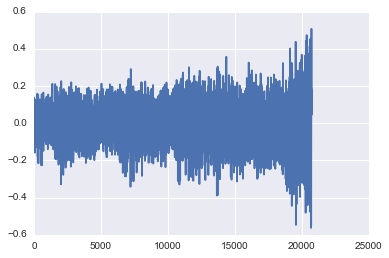

In [134]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

# show 1 sec wave segment
plt.plot(wav_segment)
filename

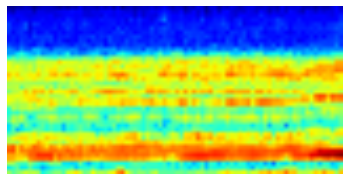

In [131]:
# show spectrogram
fig = plt.imshow(spectrogram, origin='lower')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Make 1 big array of list of spectrograms

In [135]:
# a list of many 40x80 spectrograms is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
data = np.array(list_spectrograms, dtype=config.floatX)
data.shape

(128, 40, 80)

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

As in the Car image tutorial we use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
However, this time we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

This time, we use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first.

In [136]:
# vectorize
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(128, 3200)

In [137]:
# standardize
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [138]:
# show mean and standard deviation: two vectors with same length as data.shape[1]
scaler.mean_, scaler.scale_

(array([-3.9830091 , -3.99758601, -3.99864864, -3.98593831, -3.95835662, -3.98536754, -3.97062659, -3.96252704, -3.99212098, -4.00682068, ..., -7.94232464, -7.98538733, -7.99224663, -7.94560099,
        -7.97304535, -8.01652241, -8.04188156, -8.03692818, -8.0294733 , -8.03833771], dtype=float32),
 array([ 1.04154408,  1.04758823,  1.03410363,  1.02552247,  0.98140144,  0.95631981,  0.94685912,  0.94747752,  0.99221885,  0.96500909, ...,  1.05951393,  1.06125867,  1.04087794,  1.06454217,
         1.01148212,  0.9886542 ,  0.95864058,  1.00742638,  0.98965287,  1.00467932], dtype=float32))

# Creating Train & Test Set 

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Here we compare Random Split vs. Stratified Split:

In [139]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

# Normal (random) split of data set into 2 parts
# from sklearn.model_selection import train_test_split

train_set, test_set, train_classes, test_classes = train_test_split(data, classes_num, test_size=testset_size, random_state=0)

In [140]:
train_classes

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, ..., 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])

In [141]:
test_classes

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..., 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [142]:
# The two classes may be unbalanced
print "Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes)

Class Counts: Class 0: 49 Class 1: 47


In [143]:
# better: Stratified Split retains the class balance in both sets
# from sklearn.model_selection import StratifiedShuffleSplit

if sklearn_version == '0.17':
    splits = StratifiedShuffleSplit(classes_num, n_iter=1, test_size=testset_size, random_state=0)
elif sklearn_version == '0.18':
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
    splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print "TRAIN INDEX:", train_index
    print "TEST INDEX:", test_index
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]
# Note: this for loop is only executed once, if n_iter==1 resp. n_splits==1

print train_set.shape
print test_set.shape
# Note: we will reshape the data later back to matrix form 

TRAIN INDEX: [ 97 102   0  34  13  44  60  20  75  22 ...,  43  94  65  15  26  84  30 107  10  91]
TEST INDEX: [  1  27  64 117  88  85  35  18  46 100 ...,  38  73  56 113  67  39 114  42  41  62]
(96, 3200)
(32, 3200)


In [144]:
print "Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes)

Class Counts: Class 0: 48 Class 1: 48


# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As previously in the Car image tutorial, we need to add a dimension for the color channel to the data. RGB images typically have an 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

<i>Same as in the previous tutorial:</i>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured now in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" with "tf" (Tensorflow) being the default image ordering even though you use Theano. Depending on this, use one of the code lines below.

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [145]:
n_channels = 1 # for grey-scale, 3 for RGB, but usually already present in the data

if keras.backend.image_dim_ordering() == 'th':
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_set = train_set.reshape(train_set.shape[0], n_channels, ydim, xdim)
    test_set = test_set.reshape(test_set.shape[0], n_channels, ydim, xdim)
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_set = train_set.reshape(train_set.shape[0], ydim, xdim, n_channels)
    test_set = test_set.reshape(test_set.shape[0], ydim, xdim, n_channels)

In [146]:
train_set.shape

(96, 1, 40, 80)

In [147]:
test_set.shape

(32, 1, 40, 80)

In [148]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
input_shape = train_set.shape[1:]  
input_shape

(1, 40, 80)

# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

## Creating a Single Layer and a Two Layer CNN

Try: (comment/uncomment code in the following code block)
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [173]:
#np.random.seed(0) # make results repeatable

model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
#conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, 3, 3, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.25)) 

# Layer 2
#model.add(Convolution2D(conv_filters, 3, 3))
#model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

In [174]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_42 (Convolution2D) (None, 32, 38, 78)    320         convolution2d_input_18[0][0]     
____________________________________________________________________________________________________
maxpooling2d_42 (MaxPooling2D)   (None, 32, 19, 39)    0           convolution2d_42[0][0]           
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 32, 19, 39)    0           maxpooling2d_42[0][0]            
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 32, 17, 37)    9248        dropout_8[0][0]                  
___________________________________________________________________________________________

## Training the CNN

In [175]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [176]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, nb_epoch=epochs)

Epoch 1/15
96/96 [==============================] - 0s - loss: 0.6798 - acc: 0.5312     
Epoch 2/15
96/96 [==============================] - 0s - loss: 0.6133 - acc: 0.7188     
Epoch 3/15
96/96 [==============================] - 0s - loss: 0.5744 - acc: 0.7396     
Epoch 4/15
96/96 [==============================] - 0s - loss: 0.5525 - acc: 0.7708     
Epoch 5/15
96/96 [==============================] - 0s - loss: 0.5229 - acc: 0.7917     
Epoch 6/15
96/96 [==============================] - 0s - loss: 0.5094 - acc: 0.7812     
Epoch 7/15
96/96 [==============================] - 0s - loss: 0.4959 - acc: 0.7917     
Epoch 8/15
96/96 [==============================] - 0s - loss: 0.4709 - acc: 0.8021     
Epoch 9/15
96/96 [==============================] - 0s - loss: 0.4626 - acc: 0.7812     
Epoch 10/15
96/96 [==============================] - 0s - loss: 0.4492 - acc: 0.8021     
Epoch 11/15
96/96 [==============================] - 0s - loss: 0.4348 - acc: 0.7917     
Epoch 12/15
96/96 [

#### Accuracy goes up pretty quickly for 1 layer on Train set! Also on Test set?

### Verifying Accuracy on Test Set

In [177]:
# always execute this, and then a box of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)

32/32 [==============================] - 0s


In [154]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.75

In [160]:
# 2 layer
accuracy_score(test_classes, test_pred)

0.71875

In [166]:
# 2 layer + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.75

In [172]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

0.78125

## Additional Parameters & Techniques

Try out more parameters and techniques: (comment/uncomment code blocks below)
* Adding ReLU activation
* Adding Batch normalization
* Adding Dropout

In [70]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [71]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, nb_epoch=epochs)

Epoch 1/15
96/96 [==============================] - 0s - loss: 0.8976 - acc: 0.3854     
Epoch 2/15
96/96 [==============================] - 0s - loss: 0.6631 - acc: 0.6042     
Epoch 3/15
96/96 [==============================] - 0s - loss: 0.5648 - acc: 0.6979     
Epoch 4/15
96/96 [==============================] - 0s - loss: 0.5341 - acc: 0.7292     
Epoch 5/15
96/96 [==============================] - 0s - loss: 0.4914 - acc: 0.7396     
Epoch 6/15
96/96 [==============================] - 0s - loss: 0.4904 - acc: 0.7812     
Epoch 7/15
96/96 [==============================] - 0s - loss: 0.4494 - acc: 0.7708     
Epoch 8/15
96/96 [==============================] - 0s - loss: 0.4513 - acc: 0.7917     
Epoch 9/15
96/96 [==============================] - 0s - loss: 0.4377 - acc: 0.7708     
Epoch 10/15
96/96 [==============================] - 0s - loss: 0.3864 - acc: 0.8125     
Epoch 11/15
96/96 [==============================] - 0s - loss: 0.4139 - acc: 0.8021     
Epoch 12/15
96/96 [

In [72]:
# Verifying Accuracy on Test Set

test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

32/32 [==============================] - 0s


0.75

## Parallel CNNs

It has been discovered, that CNNs for music work best, when they have one filter that is detecting frequencies in the vertical axis, and nother filter that is focused on the time axis, i.e. detecting rhythm. Consequently, this is realized in a parallel CNN, where 2 layers are not stacked after each other, but first run independently in parallel with their output being merged later.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.
In the functional API, you pass the name of the previous layer in (brackets) after defining the next layer.

In [104]:
# Input only specifies the input shape
input = Input(input_shape)

# CNN layers
# specify desired number of filters
n_filters = 16 
# The functional API allows to specify the predecessor in (brackets) after the new Layer function call
conv_layer1 = Convolution2D(n_filters, 10, 2)(input)  # a vertical filter
conv_layer2 = Convolution2D(n_filters, 2, 10)(input)  # a horizontal filter

# possibly add Activation('relu') here

# Pooling layers
maxpool1 = MaxPooling2D(pool_size=(1,2))(conv_layer1) # horizontal pooling
maxpool2 = MaxPooling2D(pool_size=(2,1))(conv_layer2) # vertical pooling

# we have to flatten the Pooling output in order to be concatenated
poolflat1 = Flatten()(maxpool1)
poolflat2 = Flatten()(maxpool2)

# Merge the 2
merged = merge([poolflat1, poolflat2], mode='concat')

full = Dense(256, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(full)

# finally create the model
model = Model(input=input, output=output_layer)

In [105]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1, 40, 80)     0                                            
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 16, 29, 73)    1552        input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_30 (Convolution2D) (None, 16, 39, 71)    336         input_5[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_29 (MaxPooling2D)   (None, 16, 29, 36)    0           convolution2d_29[0][0]           
___________________________________________________________________________________________

In [106]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [107]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, nb_epoch=epochs)

Epoch 1/15
96/96 [==============================] - 0s - loss: 0.7283 - acc: 0.6250     
Epoch 2/15
96/96 [==============================] - 0s - loss: 0.4135 - acc: 0.8646     
Epoch 3/15
96/96 [==============================] - 0s - loss: 0.3172 - acc: 0.8958     
Epoch 4/15
96/96 [==============================] - 0s - loss: 0.2749 - acc: 0.9167     
Epoch 5/15
96/96 [==============================] - 0s - loss: 0.2192 - acc: 0.9688     
Epoch 6/15
96/96 [==============================] - 0s - loss: 0.1996 - acc: 0.9479     
Epoch 7/15
96/96 [==============================] - 0s - loss: 0.1666 - acc: 0.9479     
Epoch 8/15
96/96 [==============================] - 0s - loss: 0.1377 - acc: 0.9896     
Epoch 9/15
96/96 [==============================] - 0s - loss: 0.1262 - acc: 0.9896     
Epoch 10/15
96/96 [==============================] - 0s - loss: 0.1121 - acc: 1.0000     
Epoch 11/15
96/96 [==============================] - 0s - loss: 0.1007 - acc: 1.0000     
Epoch 12/15
96/96 [

### Verifying Accuracy on Test Set

Note: The functional API, i.e. Model() does not have a convenience method `.predict_classes()`. We therefore do 'raw' predictions with `predict()`, which returns values between 0 and 1, and then round to the nearest value (0 or 1).

In [108]:
test_pred = model.predict(test_set)
test_pred[0:35,0]

array([ 0.84973729,  0.89144355,  0.05281684,  0.38995206,  0.26601386,  0.13022661,  0.13635978,  0.34884635,  0.9513182 ,  0.71613401, ...,  0.61914223,  0.14838506,  0.98934281,  0.00288095,
        0.09008534,  0.99998009,  0.05634723,  0.97572303,  0.96214837,  0.00686319], dtype=float32)

In [109]:
test_pred = np.round(test_pred)
accuracy_score(test_classes, test_pred)

0.8125

# Recurrent Neural Network: LSTM

For an RNN we define the number of time steps to be considered in a sequence. Here, we take a sequence of 10 audio samples from each audio file. The data has to be aligned accordingly to reflect the time steps, we do that in the reshape step below.

In [201]:
timesteps = 10
list_spectrograms = [] # spectrograms are put into a list first

We read all audio files again, as before we kept only 1 segment and now we process 10.

In [202]:
for filename in filelist:
    print ".", 
    filepath = os.path.join(path, filename)
    samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
    sample_length = wavedata.shape[0]

    # make Mono (in case of multiple channels / stereo)
    if wavedata.ndim > 1:
        wavedata = np.mean(wavedata, 1)
        
    # HERE WE TAKE MULTIPLE SEGMENTS NOW
    pos = 0 # start position of segment
    
    for t in range(timesteps):
        wav_segment = wavedata[pos:pos+segment_size]

        # 1) FFT spectrogram 
        spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

        # 2) Transform to perceptual Mel scale (uses librosa.filters.mel)
        spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)

        # 3) Log 10 transform
        spectrogram = np.log10(spectrogram)

        # add to lists
        list_spectrograms.append(spectrogram)
        
         # jump forward exactly by 1 segment
        pos += segment_size   # TODO check if not surpassing file length
        
print "\nRead", len(filelist), "audio files"

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Read 128 audio files


In [187]:
len(list_spectrograms)

1280

In [203]:
len(classes_num_timesteps)

1280

### Data Preprocessing (as before)

In [188]:
# make 1 big array
data = np.array(list_spectrograms, dtype=config.floatX)
data.shape

(1280, 40, 80)

In [189]:
# vectorize
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(1280, 3200)

In [190]:
# standardize
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

### Reshaping for RNN

Now, the second dimension ist not the channel (as in a CNN), but the number of time steps in a sequence to be processed.

We reshape accordingly:

In [214]:
N = data.shape[0]/timesteps  # we had N instances (* timesteps)
data = data.reshape(N, timesteps, -1)   # -1 means take the remaining dimensions from the data size given
data.shape

(128, 10, 3200)

In [217]:
input_dim = data.shape[2]
input_dim

3200

In [216]:
# alternative to input dim
input_shape = data.shape[1:]
input_shape

(10, 3200)

### Create Train/Test Set

We kept the train_index and test_index from above, and essentially split identically as before:

In [215]:
train_set = data[train_index]
test_set = data[test_index]
train_classes = classes_num[train_index]
test_classes = classes_num[test_index]

### Create LSTM Model

In [239]:
from keras.layers import LSTM

model = Sequential()

# TODO add 2-layer CNN before RNN
# conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
#model.add(Convolution2D(conv_filters, 3, 3, input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.25)) 

# Layer 2
#model.add(Convolution2D(conv_filters, 3, 3))
#model.add(MaxPooling2D(pool_size=(2, 2))) 

# In order to feed this to a Full(Dense) layer, we need to flatten all data
#model.add(Flatten()) 

# LSTM layer with 256 units
model.add(LSTM(output_dim=256, input_length=timesteps, input_dim=input_dim, activation='sigmoid', inner_activation='hard_sigmoid'))
model.add(Dropout(0.5))

# Output layer with 1 unit
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [240]:
# for RNNs take RMSprop as the optimizer!
optimizer='rmsprop'

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

epochs = 15
validation_data = (test_set, test_classes)

In [242]:
history = model.fit(train_set, train_classes, batch_size=16, nb_epoch=epochs, validation_data=validation_data)

Train on 96 samples, validate on 32 samples
Epoch 1/15
96/96 [==============================] - 0s - loss: 0.0291 - acc: 0.9896 - val_loss: 0.7074 - val_acc: 0.7188
Epoch 2/15
96/96 [==============================] - 0s - loss: 0.0319 - acc: 0.9896 - val_loss: 0.8455 - val_acc: 0.7500
Epoch 3/15
96/96 [==============================] - 0s - loss: 0.0231 - acc: 1.0000 - val_loss: 0.7720 - val_acc: 0.7812
Epoch 4/15
96/96 [==============================] - 0s - loss: 0.0196 - acc: 1.0000 - val_loss: 0.7959 - val_acc: 0.7500
Epoch 5/15
96/96 [==============================] - 0s - loss: 0.0209 - acc: 0.9896 - val_loss: 0.8374 - val_acc: 0.7500
Epoch 6/15
96/96 [==============================] - 0s - loss: 0.0091 - acc: 1.0000 - val_loss: 0.9549 - val_acc: 0.7812
Epoch 7/15
96/96 [==============================] - 0s - loss: 0.0107 - acc: 1.0000 - val_loss: 0.9507 - val_acc: 0.7812
Epoch 8/15
96/96 [==============================] - 0s - loss: 0.0064 - acc: 1.0000 - val_loss: 0.8789 - val_

### Verifying Test Set Accuracy

In [231]:
test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

32/32 [==============================] - 0s


0.75

In [224]:
# alternative
score = model.evaluate(test_set, test_classes, batch_size=16)
score

16/32 [==============>...............] - ETA: 0s

In [ ]:
# Possible Extension:
# other optimizers:
# from keras.optimizers import SGD, RMSprop, Adagrad